# Optimizer
## Proyecto final -- Optimización y Simulación
### Alejandro de Haro, Jose María Benítez, Daniel Escobosa, Pablo Berástegui

In [1]:
import pandas as pd
import pyomo.environ as pe
import pyomo.opt as po
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc

In [2]:
df = pd.read_csv('../data/players_fifa18_sample.csv')

In [3]:
chemistry = pd.read_csv('../data/sample_chemistry_edges_fifa18.csv')

In [4]:
chemistry.head()

,player_id_i,player_id_j,chem
0,222952,235051,0
1,143603,222952,0
2,222952,233616,0
3,201914,222952,2
4,163907,222952,0


## Creación del modelo

In [5]:
model = pe.ConcreteModel()

## Sets

In [6]:
# usar player_id como conjunto para que coincida con el CSV de química
relevant_cols = ['player_id', 'short_name', 'overall', 'value_eur', 'club_team_id','club_name', 'position', 'league_id', 'league_name', 'nationality_id','nationality_name', 'pace','shooting','passing','dribbling','defending','physic']
POSITIONS = ["GK", "LB", "CI", "CD", "RB", "MI", "CM", "MD", "LW", "ST", "RW"]

model.position = pe.Set(initialize=POSITIONS, ordered=True)
model.player = pe.Set(initialize=df['player_id'].astype(int).tolist())
model.club = pe.Set(initialize=df['club_team_id'].unique().tolist())
model.nationality = pe.Set(initialize=df['nationality_id'].unique().tolist())
model.league = pe.Set(initialize=df['league_id'].unique().tolist())


## Parameters

### Parametros individuales

In [7]:
overall_dict = df.set_index('player_id')['overall'].astype(float).to_dict()
model.overall = pe.Param(model.player, initialize=overall_dict, within=pe.NonNegativeReals)

pace_dict = df.set_index('player_id')['pace'].astype(float).to_dict()
model.pace = pe.Param(model.player, initialize=pace_dict, within=pe.NonNegativeReals)

value_dict = df.set_index('player_id')['value_eur'].astype(float).to_dict()
model.value= pe.Param(model.player, initialize=value_dict, within=pe.NonNegativeReals)

shooting_dict = df.set_index('player_id')['shooting'].astype(float).to_dict()
model.shooting = pe.Param(model.player, initialize=shooting_dict, within=pe.NonNegativeReals)

passing_dict = df.set_index('player_id')['passing'].astype(float).to_dict()
model.passing = pe.Param(model.player, initialize=passing_dict, within=pe.NonNegativeReals)

dribbling_dict = df.set_index('player_id')['dribbling'].astype(float).to_dict()
model.dribbling = pe.Param(model.player, initialize=dribbling_dict, within=pe.NonNegativeReals)

defending_dict = df.set_index('player_id')['defending'].astype(float).to_dict()
model.defending = pe.Param(model.player, initialize=defending_dict, within=pe.NonNegativeReals)

physic_dict = df.set_index('player_id')['physic'].astype(float).to_dict()
model.physic = pe.Param(model.player, initialize=physic_dict, within=pe.NonNegativeReals)

### Parámetro de química entre pares de jugadores

In [8]:
chemistry_dict = { (int(r.player_id_i), int(r.player_id_j)): float(r.chem)
                   for _, r in chemistry.iterrows() }

# si quieres que la química sea simétrica (chem[i,j] == chem[j,i]) descomenta:
chem_sym = {}
for (i,j), w in chemistry_dict.items():
    chem_sym[(i,j)] = w
    chem_sym[(j,i)] = w
chemistry_dict = chem_sym

model.chemistry = pe.Param(model.player, model.player,
                           initialize=chemistry_dict,
                           default=0.0,
                           within=pe.NonNegativeReals)


### FORMACIÓN 4-3-3: Conexiones entre posiciones

In [9]:
connections = np.array([
    [0,0,1,1,0,0,0,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,0],
    [1,1,0,1,0,0,1,0,0,0,0],
    [1,0,1,0,1,0,1,0,0,0,0],
    [0,0,0,1,0,0,0,1,0,0,0],
    [0,1,0,0,0,0,1,0,1,0,0],
    [0,0,1,1,0,1,0,1,0,1,0],
    [0,0,0,0,1,0,1,0,0,0,1],
    [0,0,0,0,0,1,0,0,0,1,0],
    [0,0,0,0,0,0,1,0,1,0,1],
    [0,0,0,0,0,0,0,1,0,1,0],
], dtype=int)

POSITIONS = ["GK","LB","CI","CD","RB","MI","CM","MD","LW","ST","RW"]
# Mapa posición -> índice
pos_idx = {p:i for i,p in enumerate(POSITIONS)}

def conn_init(m, i, j):
    return int(connections[pos_idx[i], pos_idx[j]])

model.conn = pe.Param(
    model.position, model.position,
    initialize=conn_init,
    within=pe.Binary,
    default=0
)

### MAPEO JUGADOR "PUEDE JUGAR EN" (can_play)

In [10]:
raw_pos = df.set_index('player_id')['position'].to_dict()

can_play = {}
for pid, rpos in raw_pos.items():
    pid = int(pid)

    if rpos == "CB":
        for pos in ["CI", "CD"]:
            can_play[(pid, pos)] = 1
    elif rpos == "CM":
        for pos in ["MI", "CM", "MD"]:
            can_play[(pid, pos)] = 1
    else:
        # si el CSV ya trae la misma etiqueta que la formación
        if rpos in POSITIONS:
            can_play[(pid, rpos)] = 1

model.can_play = pe.Param(
    model.player, model.position,
    initialize=can_play,
    within=pe.Binary,
    default=0
)

## Variables

In [11]:
model.x = pe.Var(model.player, model.position, within=pe.Binary)

# 1 si el jugador p está seleccionado (en alguna posición)
model.sel = pe.Var(model.player, within=pe.Binary)

def link_sel_rule(m, p):
    return m.sel[p] == sum(m.x[p, pos] for pos in m.position)
model.link_sel = pe.Constraint(model.player, rule=link_sel_rule)

## Funcion objetivo

In [12]:
def obj_rule(model):
    return sum(model.overall[p]*model.x[p,pos] for p in model.player for pos in model.position)
model.total_cost = pe.Objective(rule=obj_rule, sense=pe.maximize)

## Constraints

### Constraint basica

In [13]:
# Un jugador como máximo en una posición
def atmost_one_pos_rule(m, p):
    return sum(m.x[p, pos] for pos in m.position) <= 1
model.atmost_one_pos = pe.Constraint(model.player, rule=atmost_one_pos_rule)

# Cada posición de la formación se cubre exactamente con 1 jugador
def exactly_one_player_per_pos_rule(m, pos):
    return sum(m.x[p, pos] for p in m.player) == 1
model.one_player_per_pos = pe.Constraint(model.position, rule=exactly_one_player_per_pos_rule)

# (Opcional) tamaño del equipo (redundante si cubres 11 posiciones)
model.team_size = pe.Constraint(expr=sum(model.sel[p] for p in model.player) == 11)

# Restricción de "puede jugar en la posición"
def position_availability_rule(m, p, pos):
    return m.x[p, pos] <= m.can_play[p, pos]
model.position_availability = pe.Constraint(model.player, model.position, rule=position_availability_rule)

### Constraints adicionales

In [14]:
# Defensas (en tu formación 4-3-3)
DEF_POS = ["LB", "CI", "CD", "RB"]

# ---------------------------------------------------------
# 1) Media mínima de pace 75 del equipo completo
# ---------------------------------------------------------
model.MIN_AVG_PACE = pe.Param(initialize=75.0, mutable=True)

def min_avg_pace_rule(m):
    """
    Impone:
        (sum pace de los 11 seleccionados) / 11 >= MIN_AVG_PACE

    Como en tu modelo SIEMPRE seleccionas exactamente 11 jugadores (team_size==11),
    el denominador es constante y no hay necesidad de dividir.
    """
    total_pace = sum(m.pace[p] * m.sel[p] for p in m.player)
    return total_pace >= 11 * m.MIN_AVG_PACE

model.min_avg_pace = pe.Constraint(rule=min_avg_pace_rule)


# -------------------------------------------------------------------
# 2) Mínimos de defending y passing para los defensas (LB,CI,CD,RB)
# -------------------------------------------------------------------
model.MIN_DEF_DEFENDING = pe.Param(initialize=70.0, mutable=True)
model.MIN_DEF_PASSING   = pe.Param(initialize=60.0, mutable=True)
def defender_min_defending_rule(m, pos):
    if pos not in DEF_POS:
        return pe.Constraint.Skip
    return sum(m.defending[p] * m.x[p, pos] for p in m.player) >= m.MIN_DEF_DEFENDING

def defender_min_passing_rule(m, pos):
    if pos not in DEF_POS:
        return pe.Constraint.Skip
    return sum(m.passing[p] * m.x[p, pos] for p in m.player) >= m.MIN_DEF_PASSING

model.def_min_defending = pe.Constraint(model.position, rule=defender_min_defending_rule)
model.def_min_passing   = pe.Constraint(model.position, rule=defender_min_passing_rule)


# ---------------------------------------------------------
# 3) Presupuesto máximo del equipo: 50 millones de euros
# ---------------------------------------------------------
model.MAX_TEAM_VALUE = pe.Param(initialize=500_000_000.0, mutable=True)

def max_team_value_rule(m):
    total_value = sum(m.value[p] * m.sel[p] for p in m.player)
    return total_value <= m.MAX_TEAM_VALUE

model.max_team_value = pe.Constraint(rule=max_team_value_rule)


### Constraints Quimica

In [15]:
# =========================================================
# CONSTRAINT: Media de química en conexiones >= umbral
# (NO obliga a que cada relación sea >0; pueden ser 0)
# =========================================================

# Umbral de media (cambia a 1.5 si lo necesitas)
model.MIN_AVG_CHEM = pe.Param(initialize=0.3, mutable=True)

# 1) Set de aristas (pares de posiciones conectadas) SIN duplicados (i<j)
def edges_init(m):
    # Usa el orden POSITIONS / pos_idx que ya tienes definido arriba
    return [(i, j) for i in m.position for j in m.position
            if pe.value(m.conn[i, j]) == 1 and pos_idx[i] < pos_idx[j]]

model.E = pe.Set(dimen=2, initialize=edges_init)

# Número de conexiones (constante)
NUM_EDGES = len(list(model.E))

# 2) Variable auxiliar: y[p,q,i,j] = 1 si p está en i y q está en j (para (i,j) en E)
model.y = pe.Var(model.player, model.player, model.E, within=pe.Binary)

# 3) Linearización: y <= x, y >= x+x-1
def y_ub1_rule(m, p, q, i, j):
    return m.y[p, q, (i, j)] <= m.x[p, i]
model.y_ub1 = pe.Constraint(model.player, model.player, model.E, rule=y_ub1_rule)

def y_ub2_rule(m, p, q, i, j):
    return m.y[p, q, (i, j)] <= m.x[q, j]
model.y_ub2 = pe.Constraint(model.player, model.player, model.E, rule=y_ub2_rule)

def y_lb_rule(m, p, q, i, j):
    return m.y[p, q, (i, j)] >= m.x[p, i] + m.x[q, j] - 1
model.y_lb = pe.Constraint(model.player, model.player, model.E, rule=y_lb_rule)

# 4) Restricción de media: (suma química en conexiones) / NUM_EDGES >= MIN_AVG_CHEM
def min_avg_chem_rule(m):
    total_chem = sum(
        m.chemistry[p, q] * m.y[p, q, (i, j)]
        for (i, j) in m.E
        for p in m.player
        for q in m.player
    )
    return total_chem >= NUM_EDGES * m.MIN_AVG_CHEM

model.min_avg_chem = pe.Constraint(rule=min_avg_chem_rule)

## RESOLUCIÓN DEL MODELO

In [16]:
solver = po.SolverFactory('gurobi')
solver.solve(model, tee=False)

{'Problem': [{'Name': 'x1', 'Lower bound': 887.0, 'Upper bound': 887.0, 'Number of objectives': 1, 'Number of constraints': 14527173, 'Number of variables': 4846600, 'Number of binary variables': 4846600, 'Number of integer variables': 4846600, 'Number of continuous variables': 0, 'Number of nonzeros': 33975278, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '11.147562980651855', 'Error rc': 0, 'Time': 50.838587045669556}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [17]:
selected = [(p, [pos for pos in model.position if pe.value(model.x[p,pos])>0.5][0])
            for p in model.player if sum(pe.value(model.x[p,pos]) for pos in model.position)>0.5]
print(f"11 jugadores (jugador, posición): {selected}")

11 jugadores (jugador, posición): [(186153, 'GK'), (200724, 'CD'), (155862, 'CI'), (199914, 'CM'), (201223, 'MD'), (207410, 'MI'), (225402, 'RB'), (192679, 'LB'), (208722, 'RW'), (215785, 'LW'), (201818, 'ST')]


## RESUMEN DEL EQUIPO EN UN DATAFRAME

In [18]:
def resumen_equipo(model, df, selected, cols_extra=None, ordenar_por="assigned_pos"):
    """
    Devuelve un DataFrame con la info relevante del XI:
    - player_id
    - posición asignada (assigned_pos)
    - nombre, club, liga, nacionalidad
    - overall, value_eur y stats principales (si existen)
    """
    # columnas recomendadas (usa solo las que existan en df)
    base_cols = [
        "player_id", "short_name",
        "club_team_id", "club_name",
        "league_id", "league_name",
        "nationality_id", "nationality_name",
        "position",          # posición original del CSV
        "overall", "value_eur",
        "pace","shooting","passing","dribbling","defending","physic"
    ]
    if cols_extra:
        base_cols += list(cols_extra)

    base_cols = [c for c in base_cols if c in df.columns]

    # mapa player_id -> posición asignada en la solución
    asignada = dict(selected)
    ids = list(asignada.keys())

    # subset + añadir posición asignada
    out = (df[df["player_id"].astype(int).isin(ids)][base_cols]
           .copy())
    out["player_id"] = out["player_id"].astype(int)
    out["assigned_pos"] = out["player_id"].map(asignada)

    # ordenar para que salga como formación
    if ordenar_por == "assigned_pos":
        order = list(model.position)  # respeta el orden de tu Set si es ordered=True
        pos_rank = {p:i for i,p in enumerate(order)}
        out["_rank"] = out["assigned_pos"].map(pos_rank)
        out = out.sort_values("_rank").drop(columns=["_rank"])
    else:
        out = out.sort_values(ordenar_por)

    # (opcional) métricas resumen rápidas
    resumen = {
        "total_value_eur": float(out["value_eur"].sum()) if "value_eur" in out else None,
        "avg_overall": float(out["overall"].mean()) if "overall" in out else None,
    }

    return out.reset_index(drop=True), resumen


# USO:
equipo_df, metrics = resumen_equipo(model, df, selected)
print(equipo_df)
print(metrics)

    player_id       short_name  club_team_id       club_name  league_id  \
0      186153      W. Szczęsny          45.0        Juventus       31.0   
1      192679         Escudero         481.0         Sevilla       53.0   
2      155862     Sergio Ramos         243.0     Real Madrid       53.0   
3      200724  Nacho Fernández         243.0     Real Madrid       53.0   
4      225402     Bruno Gaspar      110374.0      Fiorentina       31.0   
5      207410       M. Kovačić         243.0     Real Madrid       53.0   
6      199914            Allan          48.0          Napoli       31.0   
7      201223        A. Acquah          54.0          Torino       31.0   
8      215785         K. Baldé          69.0          Monaco       16.0   
9      201818          A. Musa          95.0  Leicester City       13.0   
10     208722          S. Mané           9.0       Liverpool       13.0   

       league_name  nationality_id nationality_name position  overall  \
0          Serie A        

### DIBUJAR ALINEACIÓN DEFINITIVA

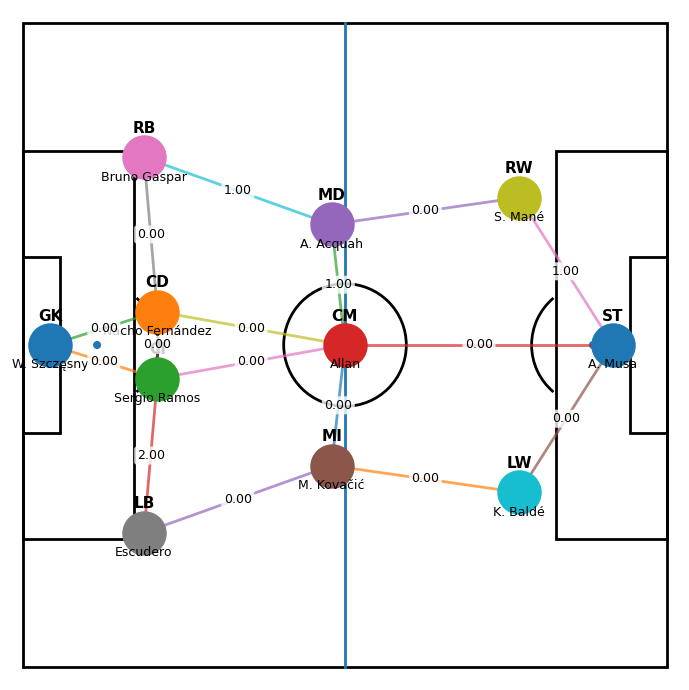

In [20]:
# =========================
# Mapa player_id -> nombre
# =========================
# Usamos short_name para que el texto sea compacto en el campo
player_name = (
    df.set_index("player_id")["short_name"]
      .astype(str)
      .to_dict()
)

# =========================
# Coordenadas por posición
# (campo normalizado 0–100)
# =========================
pos_xy = {
    'GK': (6, 50),

    'LB': (20, 22),
    'CI': (22, 45),
    'CD': (22, 55),
    'RB': (20, 78),

    'MI': (48, 32),
    'CM': (50, 50),
    'MD': (48, 68),

    'LW': (76, 28),
    'RW': (76, 72),
    'ST': (90, 50),
}

# =========================
# Dibujo del campo
# =========================
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_aspect('equal')
ax.axis('off')

# Líneas exteriores
ax.add_patch(Rectangle((2, 2), 96, 96, fill=False, linewidth=2))

# Línea central
ax.plot([50, 50], [2, 98], linewidth=2)

# Círculo central
ax.add_patch(Circle((50, 50), 9.15, fill=False, linewidth=2))
ax.add_patch(Circle((50, 50), 0.6))

# Área izquierda
ax.add_patch(Rectangle((2, 21.1), 16.5, 57.8, fill=False, linewidth=2))
ax.add_patch(Rectangle((2, 36.8), 5.5, 26.4, fill=False, linewidth=2))
ax.add_patch(Circle((13, 50), 0.6))
ax.add_patch(Arc((13, 50), 18.3, 18.3, theta1=310, theta2=50, linewidth=2))

# Área derecha
ax.add_patch(Rectangle((81.5, 21.1), 16.5, 57.8, fill=False, linewidth=2))
ax.add_patch(Rectangle((92.5, 36.8), 5.5, 26.4, fill=False, linewidth=2))
ax.add_patch(Circle((87, 50), 0.6))
ax.add_patch(Arc((87, 50), 18.3, 18.3, theta1=130, theta2=230, linewidth=2))

# =========================
# Plot de jugadores
# =========================
pos_to_player = {pos: pid for pid, pos in selected}

for player_id, pos in selected:
    x, y = pos_xy[pos]

    # Dibuja el jugador
    ax.scatter(x, y, s=900, linewidths=2, zorder=3)

    # Etiqueta de la posición (arriba)
    ax.text(
        x, y + 3.2,
        pos,
        ha='center', va='bottom',
        fontsize=11, fontweight='bold',
        zorder=4
    )

    # Nombre del jugador (abajo)
    ax.text(
        x, y - 2.0,
        player_name.get(player_id, str(player_id)),
        ha='center', va='top',
        fontsize=9,
        zorder=4
    )

# =========================
# Dibujar relaciones (matriz de conexiones) + valor de química
# =========================
# Recorre pares de posiciones conectadas (conn==1) y dibuja línea + etiqueta con chem
pos_list = list(model.position)
for i in range(len(pos_list)):
    for j in range(i + 1, len(pos_list)):
        pi, pj = pos_list[i], pos_list[j]

        if int(pe.value(model.conn[pi, pj])) != 1:
            continue

        # Deben existir en el XI
        if pi not in pos_to_player or pj not in pos_to_player:
            continue

        a = pos_to_player[pi]
        b = pos_to_player[pj]

        x1, y1 = pos_xy[pi]
        x2, y2 = pos_xy[pj]

        # Línea de conexión
        ax.plot([x1, x2], [y1, y2], linewidth=2, alpha=0.7, zorder=2)

        # Valor de química entre jugadores asignados a esas posiciones
        chem_val = float(pe.value(model.chemistry[a, b]))

        # Etiqueta en el punto medio
        mx, my = (x1 + x2) / 2, (y1 + y2) / 2
        ax.text(
            mx, my,
            f"{chem_val:.2f}",
            ha="center", va="center",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8, linewidth=0),
            zorder=5
        )

# =========================
# Guardar imagen
# =========================
plt.tight_layout()
plt.show()